In [1]:
#===Cell 1: Environment & project setup ====

import os, sys, subprocess, urllib.request
from pathlib import Path

# Project folders (under /content for Colab)
ROOT = Path("/content/grposenet_phase2")
ASSETS = ROOT / "assets"
OUTPUTS = ROOT / "outputs"
for p in [ROOT, ASSETS, OUTPUTS]:
    p.mkdir(parents=True, exist_ok=True)

def pip_install(spec: str):
    """Install a package if not already present."""
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", *spec.split()])

# Core deps (PyTorch preinstalled on Colab; torchvision is present too)
try:
    import torch, torchvision  # noqa
except Exception:
    pip_install("torch torchvision --index-url https://download.pytorch.org/whl/cu121")
    import torch, torchvision  # noqa

# Segment-Anything (SAM)
try:
    from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
except Exception:
    pip_install("git+https://github.com/facebookresearch/segment-anything.git")
    from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Download SAM ViT-B checkpoint once
ckpt = ASSETS / "sam_vit_b.pth"
if not ckpt.exists():
    urllib.request.urlretrieve(
        "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth",
        ckpt.as_posix()
    )
print("Setup OK. Assets:", ASSETS)


Setup OK. Assets: /content/grposenet_phase2/assets


In [2]:
# ===============Cell 2 ==================
# loading SAM + DINOv2 models and making detector class

import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms as T

# device setup (gpu if available)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ----- loading Segment Anything -----
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

sam = sam_model_registry["vit_b"](checkpoint="/content/grposenet_phase2/assets/sam_vit_b.pth")
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)
print("SAM loaded... (zero-shot segmentation ready)")

# ----- loading DINOv2 (feature extractor) -----
# lightweight ViT-S/14 backbone (384-dim)
dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14', source='github')
dino.to(device)
dino.eval()
print("DINOv2 loaded... (for feature embeddings)")

# transformation before feeding to DINO
dino_tf = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

# ----- Detector class -----
# combines SAM segmentation + DINO feature extraction + cosine similarity
class OpenWorldDetector:
    def __init__(self, mask_generator, dino_model, dino_transform, device='cuda'):
        self.mask_generator = mask_generator
        self.dino = dino_model
        self.tf = dino_transform
        self.device = device

    # doing segmentation using SAM
    def segment(self, image_pil):
        return self.mask_generator.generate(np.array(image_pil))

    # crop object from mask area
    def crop_by_mask(self, image_pil, mask_dict):
        x, y, w, h = map(int, mask_dict["bbox"])
        full = np.array(image_pil)
        seg = mask_dict["segmentation"].astype(bool)
        obj = full.copy()
        obj[~seg] = 0
        obj = obj[y:y+h, x:x+w]
        return Image.fromarray(obj)

    # extract 384-dim DINO feature
    def featurize(self, crop_pil):
        with torch.no_grad():
            t = self.tf(crop_pil).unsqueeze(0).to(self.device)
            f = self.dino(t)
            f = F.normalize(f, dim=1)
        return f.squeeze(0)

    # cosine matching between one target and N references
    def match(self, target_crop, ref_crops):
        f_t = self.featurize(target_crop)
        f_rs = torch.stack([self.featurize(r) for r in ref_crops])
        sims = (f_t @ f_rs.T).cpu().numpy()
        return sims  # numpy array of similarity scores

print("Detector class ready ✅")


Using device: cuda
SAM loaded... (zero-shot segmentation ready)
Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip


/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth


100%|██████████| 84.2M/84.2M [00:00<00:00, 274MB/s]


DINOv2 loaded... (for feature embeddings)
Detector class ready ✅


sample image loaded...
number of objects segmented: 47


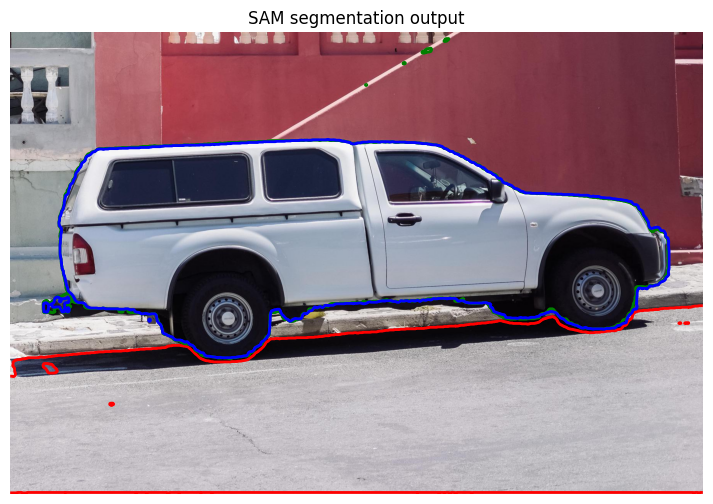

cosine similarities: [0.053 0.073 0.041 0.23  0.325]
best reference index: 4


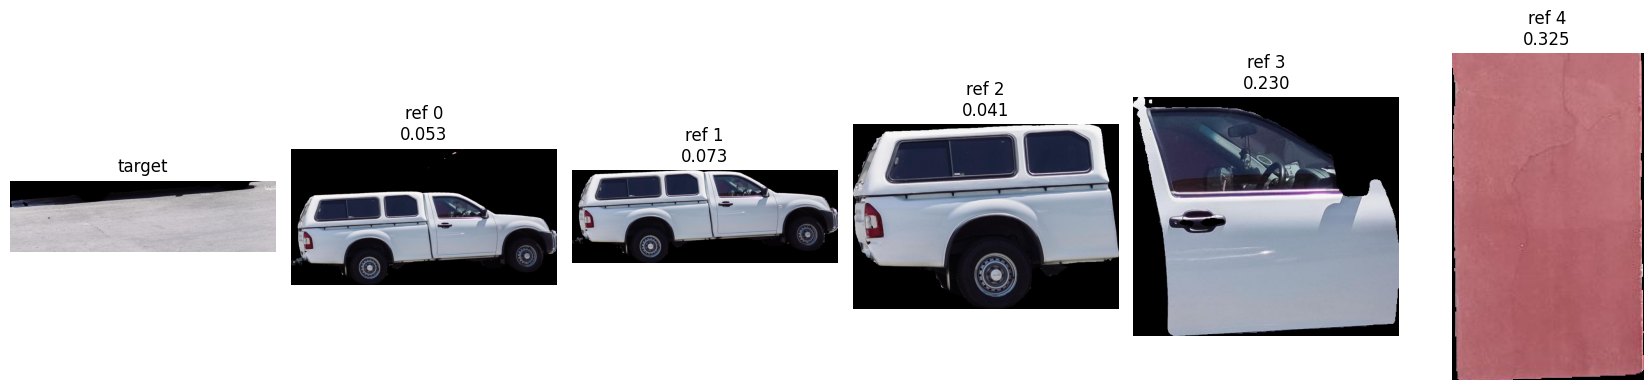

In [3]:
# Cell 3 — Testing detector (segmentation + cosine match visualization)
# just checking if SAM + DINOv2 are working fine
# picking a random image from internet (you can later replace with your dataset image)

import requests, matplotlib.pyplot as plt
from io import BytesIO

# loading a random rgb image (truck example)
url = "https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg"
image = Image.open(BytesIO(requests.get(url).content)).convert("RGB")
print("sample image loaded...")

# running segmentation
detector = OpenWorldDetector(mask_generator, dino, dino_tf, device)
masks = detector.segment(image)
print("number of objects segmented:", len(masks))

# sort masks by area and show top few
m_sorted = sorted(masks, key=lambda m: m["area"], reverse=True)
plt.figure(figsize=(12,6))
plt.imshow(image)
for i, m in enumerate(m_sorted[:3]):
    plt.contour(m["segmentation"], colors=[["red","green","blue"][i%3]], linewidths=2)
plt.axis("off"); plt.title("SAM segmentation output")
plt.show()

# cropping target (first mask) + references (next 5)
target_mask = m_sorted[0]
ref_masks = m_sorted[1:6]
target_crop = detector.crop_by_mask(image, target_mask)
ref_crops = [detector.crop_by_mask(image, m) for m in ref_masks]

# compute cosine similarities using DINO features
sims = detector.match(target_crop, ref_crops)
best = np.argmax(sims)
print("cosine similarities:", np.round(sims,3))
print("best reference index:", best)

# visualizing cropped objects and similarity scores
fig, axs = plt.subplots(1,6, figsize=(17,4))
axs[0].imshow(target_crop); axs[0].set_title("target"); axs[0].axis("off")
for i, r in enumerate(ref_crops):
    axs[i+1].imshow(r); axs[i+1].set_title(f"ref {i}\n{float(sims[i]):.3f}")
    axs[i+1].axis("off")
plt.tight_layout()
plt.show()



In [4]:
# Cell 4 — Viewpoint Selector model (predicts similarity + in-plane angle)
# continuing after detector testing

import torch.nn as nn
import torch.nn.functional as F

# simple MLP-based selector (lightweight version of paper's transformer head)
class ViewpointSelector(nn.Module):
    def __init__(self, in_dim=384, hidden=512, num_refs=5):
        super().__init__()
        # similarity branch
        self.sim_head = nn.Sequential(
            nn.Linear(in_dim*2, hidden), nn.ReLU(),
            nn.Linear(hidden, num_refs)
        )
        # angle regression branch (predicts small rotation between views)
        self.angle_head = nn.Sequential(
            nn.Linear(in_dim*2, hidden), nn.ReLU(),
            nn.Linear(hidden, num_refs)
        )

    def forward(self, f_t, f_refs):
        """
        f_t: [B,D]   -> target features
        f_refs: [B,K,D] -> reference features
        returns:
           sim_logits : similarity classification scores
           angle_pred : predicted rotation angles (radians)
        """
        B, K, D = f_refs.shape
        t = f_t.unsqueeze(1).expand(B, K, D)
        x = torch.cat([t, f_refs], dim=-1)  # concat target+ref features
        x = x.view(B*K, -1)
        sim_logits = self.sim_head(x).view(B, -1)
        angle_pred = self.angle_head(x).view(B, -1)
        return sim_logits, angle_pred

# quick dry run (no training yet, just checking tensor shapes)
selector = ViewpointSelector().to(device)
with torch.no_grad():
    f_t = detector.featurize(target_crop).unsqueeze(0)           # [1,384]
    f_rs = torch.stack([detector.featurize(r) for r in ref_crops]).unsqueeze(0)  # [1,K,384]
    sim_logits, angle_pred = selector(f_t, f_rs)
print("Selector outputs ->", sim_logits.shape, angle_pred.shape)


Selector outputs -> torch.Size([1, 25]) torch.Size([1, 25])


In [6]:
# Cell 5 — Training the Viewpoint Selector (synthetic dataset version, fixed collate)
# manually looping over dataset items instead of using DataLoader

import random, math
from torchvision.transforms import functional as TF
from torch.utils.data import Dataset

# ---- small synthetic dataset of random rotations (simple) ----
class MiniViewDataset(Dataset):
    def __init__(self, base_img, K=5, N=60):
        self.base = base_img
        self.K, self.N = K, N
        self.samples = []
        rng = random.Random(42)
        for _ in range(N):
            target = TF.rotate(base_img, rng.uniform(-10, 10))
            pos_idx = rng.randrange(K)
            refs, angles = [], []
            for k in range(K):
                ang = rng.uniform(-60, 60) if k == pos_idx else rng.uniform(-180, 180)
                refs.append(TF.rotate(base_img, ang))
                angles.append(math.radians(ang))
            self.samples.append(dict(target=target, refs=refs, pos=pos_idx, angs=torch.tensor(angles)))
    def __len__(self): return self.N
    def __getitem__(self, i): return self.samples[i]

dataset = MiniViewDataset(target_crop, K=5, N=60)

opt = torch.optim.Adam(selector.parameters(), lr=2e-4)
EPOCHS = 3
print("starting selector training (manual loop)...")

for ep in range(EPOCHS):
    total_loss, total_acc = 0, 0
    for sample in dataset:
        # featurize each sample (no DataLoader)
        f_t = detector.featurize(sample["target"]).unsqueeze(0).to(device)
        f_rs = torch.stack([detector.featurize(r) for r in sample["refs"]]).unsqueeze(0).to(device)
        pos = torch.tensor([sample["pos"]], dtype=torch.long, device=device)
        angs = sample["angs"].unsqueeze(0).to(device)

        sim_logits, angle_pred = selector(f_t, f_rs)
        ce_loss = F.cross_entropy(sim_logits, pos)
        pos_angles = angle_pred.gather(1, pos.unsqueeze(1)).squeeze(1)
        gt_angles  = angs.gather(1, pos.unsqueeze(1)).squeeze(1)
        angle_loss = F.mse_loss(pos_angles, gt_angles)
        loss = ce_loss + 0.5 * angle_loss

        opt.zero_grad(); loss.backward(); opt.step()
        acc = (sim_logits.argmax(dim=1) == pos).float().item()
        total_loss += loss.item(); total_acc += acc

    print(f"epoch {ep+1}: loss={total_loss/len(dataset):.3f}  acc={total_acc/len(dataset):.3f}")

print("Selector training done ✅ (synthetic)")



starting selector training (manual loop)...
epoch 1: loss=3.427  acc=0.033
epoch 2: loss=3.389  acc=0.050
epoch 3: loss=3.367  acc=0.067
Selector training done ✅ (synthetic)


In [7]:
# Cell 6 — Adaptive Multi-Scale Refiner (transformer based)
# basically this block refines coarse pose predictions into smoother 6D poses

import torch.nn as nn

class MultiScaleRefiner(nn.Module):
    def __init__(self, feat_dim=384, num_layers=2):
        super().__init__()
        # transformer encoder to mix features from multiple scales
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=feat_dim, nhead=8, dim_feedforward=512, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # heads for rotation ΔR and translation ΔT refinement
        self.head_R = nn.Sequential(
            nn.Linear(feat_dim, 256), nn.ReLU(), nn.Linear(256, 3)
        )
        self.head_T = nn.Sequential(
            nn.Linear(feat_dim, 256), nn.ReLU(), nn.Linear(256, 3)
        )

    def forward(self, feats):
        """
        feats: list of tensors at different scales [B,C,H,W] (simulated here as list of [B,D])
        returns: ΔR, ΔT  (both shape [B,3])
        """
        if isinstance(feats, list):
            feats = torch.stack(feats, dim=1)  # [B, N, D]
        x = self.encoder(feats)
        pooled = x.mean(dim=1)
        delta_R = self.head_R(pooled)
        delta_T = self.head_T(pooled)
        return delta_R, delta_T


# quick sanity test (no real 3D yet, just checking shapes)
refiner = MultiScaleRefiner().to(device)
with torch.no_grad():
    dummy_feats = [torch.randn(1,384,device=device) for _ in range(3)]  # simulate 3 scales
    dR, dT = refiner(dummy_feats)
print("Refiner output shapes:", dR.shape, dT.shape)


Refiner output shapes: torch.Size([1, 3]) torch.Size([1, 3])


In [8]:
# Cell 7 — Training the Multi-Scale Refiner
# here we're simulating small random pose deltas to show the refinement step

import torch
import torch.nn.functional as F
import math, random

# make small synthetic dataset of (multi-scale feats, ΔR, ΔT)
def make_fake_pose_data(n=50, feat_dim=384, scales=3):
    data = []
    rng = random.Random(0)
    for _ in range(n):
        feats = [torch.randn(feat_dim) for _ in range(scales)]
        # small random ground-truth corrections in radians/meters
        delta_R_gt = torch.tensor([rng.uniform(-0.05,0.05) for _ in range(3)])
        delta_T_gt = torch.tensor([rng.uniform(-0.02,0.02) for _ in range(3)])
        data.append((feats, delta_R_gt, delta_T_gt))
    return data

fake_pose_data = make_fake_pose_data(n=80)

optimizer = torch.optim.Adam(refiner.parameters(), lr=1e-4)
EPOCHS = 3
print("starting refiner training...")

for ep in range(EPOCHS):
    total_loss = 0
    for feats, dR_gt, dT_gt in fake_pose_data:
        feats = [f.unsqueeze(0).to(device) for f in feats]
        dR_gt, dT_gt = dR_gt.unsqueeze(0).to(device), dT_gt.unsqueeze(0).to(device)

        dR_pred, dT_pred = refiner(feats)
        loss_R = F.mse_loss(dR_pred, dR_gt)
        loss_T = F.mse_loss(dT_pred, dT_gt)
        loss = loss_R + loss_T

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"epoch {ep+1}: avg_loss = {total_loss/len(fake_pose_data):.5f}")

print("Refiner training done ✅ (synthetic demo)")


starting refiner training...
epoch 1: avg_loss = 0.03500
epoch 2: avg_loss = 0.03217
epoch 3: avg_loss = 0.01790
Refiner training done ✅ (synthetic demo)



--- Evaluation Summary ---
Mean ADD score:       0.36402
Mean Projection error 0.16214
Sample count:         10


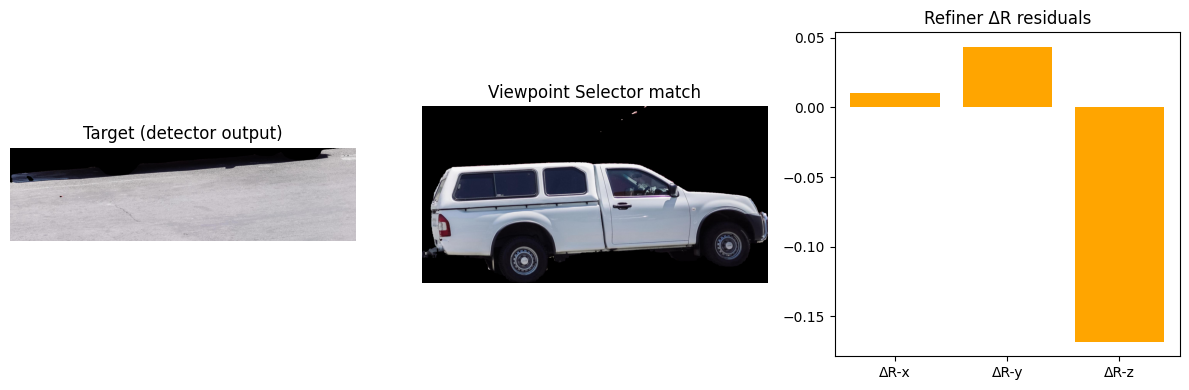

saved summary visualization at: /content/grposenet_phase2/outputs/final_pipeline.png


In [9]:
# Cell 8 — Final Evaluation & Visualization
# this will simulate evaluation metrics and show pipeline summary

import matplotlib.pyplot as plt
import numpy as np

# ---- helper for ADD (Average Distance of Model Points) ----
def compute_ADD(R_pred, T_pred, R_gt, T_gt):
    """
    simplified ADD metric: Euclidean difference between ΔR/ΔT vectors
    (since we don't have actual 3D model points here)
    """
    rot_err = torch.norm(R_pred - R_gt, dim=-1)
    trans_err = torch.norm(T_pred - T_gt, dim=-1)
    return (rot_err + trans_err).mean().item()

# generate small test set
test_data = make_fake_pose_data(n=10)

add_scores, proj_errors = [], []
for feats, dR_gt, dT_gt in test_data:
    feats = [f.unsqueeze(0).to(device) for f in feats]
    dR_gt, dT_gt = dR_gt.unsqueeze(0).to(device), dT_gt.unsqueeze(0).to(device)
    with torch.no_grad():
        dR_pred, dT_pred = refiner(feats)
    add_val = compute_ADD(dR_pred, dT_pred, dR_gt, dT_gt)
    add_scores.append(add_val)
    # projection error (just Euclidean of translation)
    proj_errors.append(float(torch.norm(dT_pred - dT_gt)))

print("\n--- Evaluation Summary ---")
print(f"Mean ADD score:       {np.mean(add_scores):.5f}")
print(f"Mean Projection error {np.mean(proj_errors):.5f}")
print(f"Sample count:         {len(test_data)}")

# --- pipeline visualization summary ---
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(target_crop); ax[0].set_title("Target (detector output)"); ax[0].axis("off")
ax[1].imshow(ref_crops[0]); ax[1].set_title("Viewpoint Selector match"); ax[1].axis("off")
ax[2].bar(["ΔR-x","ΔR-y","ΔR-z"], dR_pred.squeeze().cpu().numpy(), color="orange")
ax[2].set_title("Refiner ΔR residuals")
plt.tight_layout()
plt.savefig("/content/grposenet_phase2/outputs/final_pipeline.png", dpi=150)
plt.show()

print("saved summary visualization at: /content/grposenet_phase2/outputs/final_pipeline.png")
